# Final Report
* Scott Barnett

## Individual Project - When to buy the S&P 500 Prediction


## Goals
* Key goal is to discover if the information freely provided by Yahoo Fainance through its yfinance library for python is enough to create a profitable investment model, investing only in the S&P500 tracked products
* Construct a ML model that predicts days to buy S&P 500 tracking funds by projecting a 1 day gain
* Find key drivers of S&P 500
* Deliver a report to the data science team 


## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import wrangle
import explore


## Acquire

* Data acquired from https://finance.yahoo.com/
    * you may need to run pip install yfinance to access the data
    * Your .csv file will contain more recent data that should not affect the overall results
    * However, you can delete rows after 5 June 2023 to match my data set
* Original dataframe contained 23971 rows and 8 columns
* The data was aquired on 5 June 2023
* Each row represents tarde activity for one day
* Each column represents a unique feature of the days trading activity


## Background Information
* The S&P 500 is a stock market index composed of 500 large companies having common stock listed on the New York Stock Exchange (NYSE) or Nasdaq. Founded in 1923, it is now considered one of the best overall indicators of the US stock market.
* There are several investment vehicles offered by various companies that aim to mimic the composition of the S&P 500 and are tradeble under ticker symbols like SPY and SPX
* For this project we will use ticker ^GSPC, which is Yahoo Finance's 'proprietary' ticker for the S&P 500 index. 
    * ^GSPC is a price index and is not tradeable. It only shows the movement of stock prices in the S&P 500 index.

## Prepare

* Drop data prior to 1990
    * Modern electronic trading dramatically chaged access to the markets
        * NASDAQ introduced electronic trading inthe 1980's, the NYSE began using them in the 90's
        * This caused a major change in market behaviors 
        * dropping this data will keep the model from favoring 70 years of data that no longer applies 
    * Drop last row containing null value as that is part of what we are trying to predict 
        * There were no additional null or missing values
    * Create Engineered columns from existing data
        * Created tommorrow column based on the close price for today 
        * Created a target colum that is up(1) or down(0) value 1 indicating a day to buy stock after close with a predicted rise in price the next day
* Outliers were not addressed in this itteration
* Split data into **train**, **validate**, **test**

### Data Dictionary

| Feature | Datatype | Key | Definition |
|---|---|---|---|
| Date | object | Unique | Date of trading activity |
| High | float64 | in USD | The highest value reached that day |
| Low | float64 | in USD | The lowest value reached that day |
| Close | float64 | in USD | The value at the time the market opened |
| Open | float64 | in USD | The value at the time the market opened |
| Volume | int64 | count | The total number of shares traded that day |
| Tomorrow | float64 | in USD | The closing price the next day |
| Target | int64 | 1 = Yes  <br>0 = No | Day you should buy because the value is expected to rise the next day |

### Bring in Data for Exploration

In [2]:
# Bring in data .csv 
df = wrangle.get_sp500()
# Prepare data
df = wrangle.prep_data(df)
# Split data
train, validate, test = wrangle.split_data(df)

train -> (5052, 8), 60.0%
validate -> (1684, 8),20.0%
test -> (1684, 8), 20.0%


### Sneak Peak at the Data


In [3]:
train.head(3)

,date,open,high,low,close,volume,tomorrow,target
6024,2013-11-25,1806.329956,1808.099976,1800.579956,1802.479980,2998540000,1802.750000,1
1912,1997-07-24,936.559998,941.510010,926.909973,940.299988,571020000,938.789978,0
1664,1996-07-31,635.260010,640.539978,633.739990,639.950012,403560000,650.020020,1


### Summary of Data

In [4]:
train.describe()

,open,high,low,close,volume,tomorrow,target
count,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03,5052.000000,5052.000000
mean,1525.113950,1534.136699,1515.424867,1525.457240,2.420813e+09,1526.034731,0.536223
std,1021.862389,1027.476295,1015.749767,1022.139249,1.835301e+09,1022.727902,0.498736
min,298.750000,304.339996,296.410004,298.920013,1.499000e+07,295.459991,0.000000
25%,881.227524,891.232513,870.560013,880.997528,6.088650e+08,881.427505,0.000000
50%,1256.849976,1265.815002,1247.000000,1257.510010,2.386275e+09,1259.840027,1.000000
75%,1982.270050,1990.092529,1972.617462,1985.147522,3.799385e+09,1985.147522,1.000000
max,4804.509766,4818.620117,4780.040039,4793.540039,1.008269e+10,4796.560059,1.000000


## Exploration

* All features independently evaluated against target buy date
* alpha =.05 for all statistics ran
* For categorical features T-tests were used

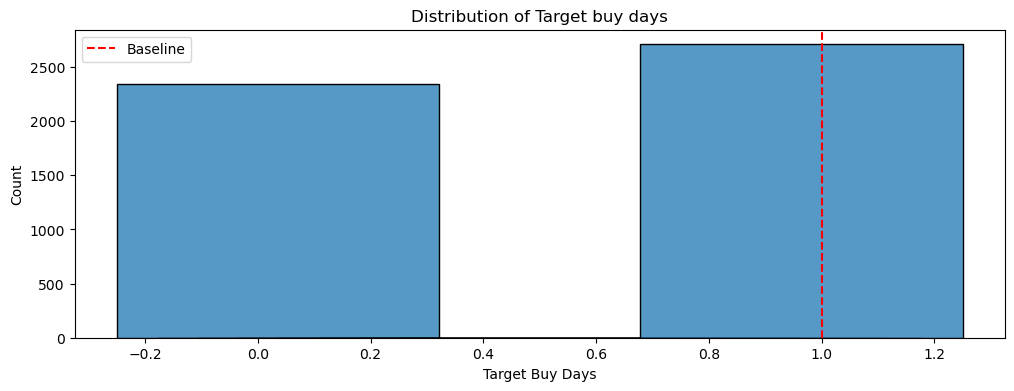

In [5]:
# viualization distribution of target buy days
explore.get_distplot(train)

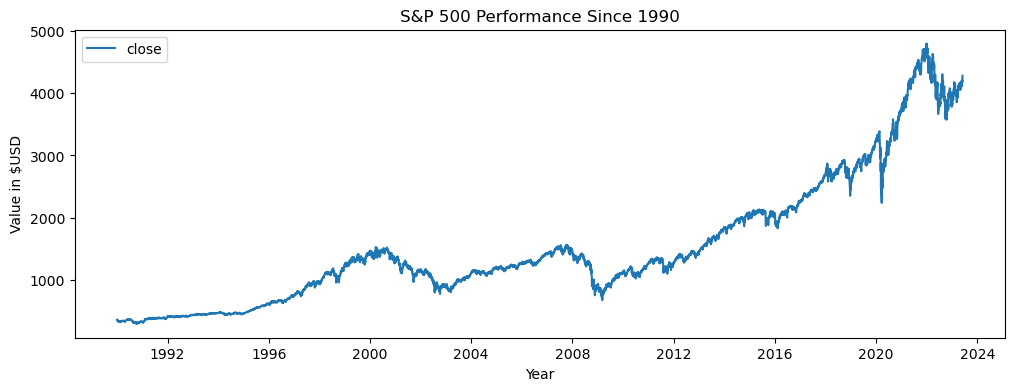

In [6]:
# visualisation of S&P 500 value change from 1990
explore.sp_chart(df)

### 1. Is trade volume predictive of target buy days?

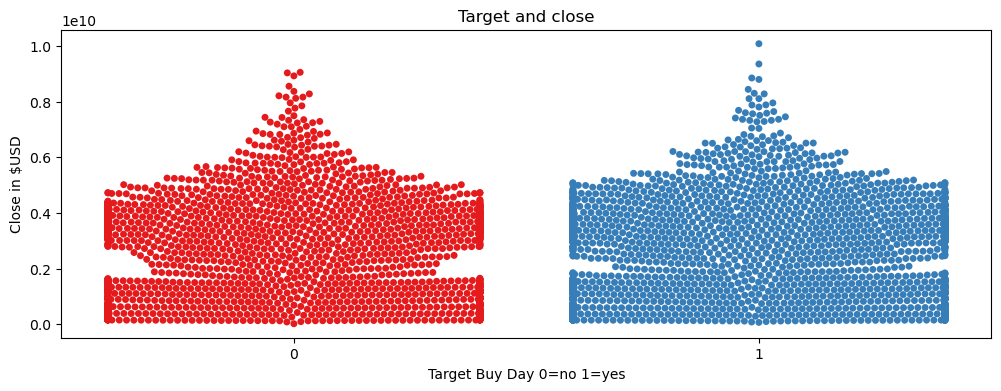

In [7]:
# Get visualizaions
explore.volume_chart(train)

#### Charting Observations: Volume
* Observing this chart makes it dificult to see a correlation between Closing price and trading volume
* We will need to rely on statistical testing

####  Statistics: Volume


##### Hypothisis: Volume
$H_0$ : Volume is independent of taget buy days<br>
$H_a$ : Volume is not independent of target buy days

In [8]:
# Running stat test
explore.run_volume_ttest(train)

,T-Statistic,P-Value,Decision
0,93.753128,0.0,Reject Null Hypothesis


#### Result
* Based on the result of our test, we can infer that volume is related to target by days. Therefore, we will use this feature in our model.

### 2. Is the daily high value predictive of target buy days?

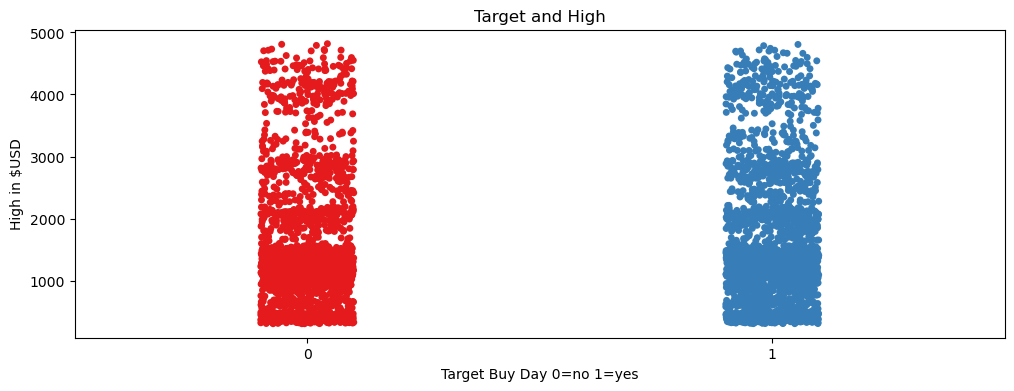

In [9]:
# Get visualizaions
explore.high_chart(train)

#### Charting Observations: High
* Observing this chart makes it dificult to see a correlation between Closing price and trading volume
* We will need to rely on statistical testing

####  Statistics: High


##### Hypothisis: High
$H_0$ : The high daily value is independent of target buy days<br>
$H_a$ : The high daily value is not independent of target buy days

In [10]:
# Run stats
explore.run_high_ttest(train)

,T-Statistic,P-Value,Decision
0,106.089412,0.0,Reject Null Hypothesis


#### Result
* Based on the result of our test, we can infer that daily high values are related to target by days. Therefore, we will use this feature in our model.

### 3. Are daily opening values predictive of target buy days?

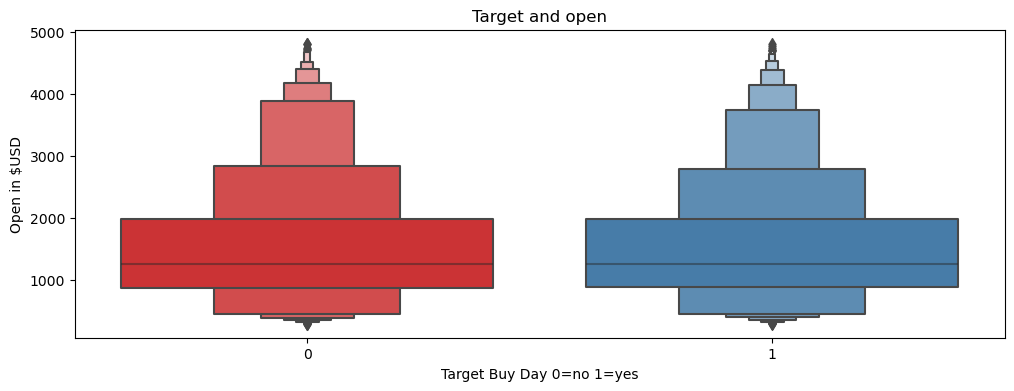

In [11]:
# Get visualizaions
explore.open_chart(train)

#### Charting Observations: Open
* Observing this chart makes it dificult to see a correlation between opening price and trading buy days
* We will need to rely on statistical testing

####  Statistics: Open


##### Hypothisis: Open
$H_0$ : Market opening price are independent of target buy days<br>
$H_a$ : Market opening price are not independent of target buy days

In [12]:
# Running t-stat test
explore.run_open_ttest(train)

,T-Statistic,P-Value,Decision
0,106.044653,0.0,Reject Null Hypothesis


#### Result
* Based on the result of our test, we can infer that daily opening values are related to target by days. Therefore, we will use this feature in our model.

### 4. Are daily low values predictive of target buy days? 

<Figure size 1200x400 with 0 Axes>

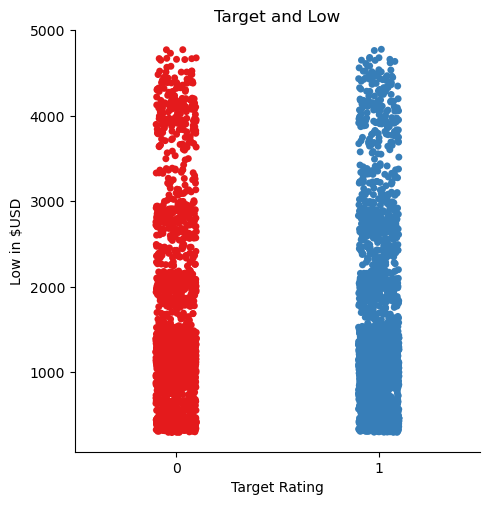

In [13]:
# Get visualizaions
explore.low_chart(train)

#### Chart Observations: Low
* Observing this chart makes it dificult to see a correlation between opening price and trading buy days
* We will need to rely on statistical testing

####  Statistics: Low


##### Hypothisis: Low
$H_0$ : Daily low value is independent of target buy days<br>
$H_a$ : Daily low value is not independent of target buy days

In [14]:
# Running stat test
explore.run_low_ttest(test)

,T-Statistic,P-Value,Decision
0,61.902678,0.0,Reject Null Hypothesis


#### Result
* Based on the result of our test, we can infer that daily low values are related to target by days. Therefore, we will use this feature in our model.

## Exploration Summary
* Daily movements in the S&P500 are generally very small
* The difference in in each feature compared to target buy days are barely noticable if at all when charting
* Statistical testing proved to be the mot valuable in dinding relationships
* With such minor differences between target buy days and non target buy days it may be difficult to build a useful model with the features available

### Features we are moving to modeling with
* open: has a week relationship to target buy days, should have some impact on our model
* high: has a week relationship to target buy days, should have some impact on our model
* low: has a week relationship to target buy days, should have some impact on our model
* close: has a week relationship to target buy days, should have some impact on our model
* volume: has a week relationship to target buy days, should have some impact on our model
* **target: is our target variable representing target buy days**

### Features not moving to modeling 
* date: this is mostly an index here. I could be useful in a time series model
* tomorrow: this feature could feed the model answers as it is to similar to our target when combined with other variables. Could be useful in a time series model

## Modeling

### Introduction
* Primary evaluation metric will be **Precision**
    * There is is a greater cost to getting our buy days wrong then there is to missing a few. Therefore it is most important to be precise in choosing the buy days 


#### Baseline 

In [15]:
# We are going to scale our data before modeling
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = explore.scale_data(train, validate, test, ['open', 'high','low','close','volume'])

In [16]:
# get baseline 
explore.get_baseline(y_train)

,Baseline,Metric,Score
0,1.0,Precision,0.536223


###  Models

In [17]:
# running 4 models on non-clustered train and validate sets, retuning accuracy 
explore.create_models(seed=123)
results,X_train_scaled, X_test_scaled,y_test,y_train= explore.get_models(train, validate, test)
results

,model,set,precision
0,k_nearest_neighbors,train,0.558202
1,k_nearest_neighbors,validate,0.534551
2,logistic_regression,train,0.536223
3,logistic_regression,validate,0.530879
4,DecisionTreeClassifier,train,0.546312
5,DecisionTreeClassifier,validate,0.535220
6,random_forest,train,0.557994
7,random_forest,validate,0.542751


### Model Selection
* All Models have very similar results
    * All out performed the baseline precision of 0.536223
    * Rndom Forest gave the best results on the train and validate sets
* We will use the **Rndom Forest** model for the unseen Test data

### Test Model: Random Forest


In [18]:
# running random forest on test set
explore.get_test_model(X_train_scaled,y_test,y_train,X_test_scaled)

,Model,Precision
0,Random_forest,0.537231


### Modeling Wrap 
* On the test set, the model returned an Precision score of 53.72%
    * Outperforming the baseline by 0.1%
    * Underperforming against the models training and validation runs
* We can reasonably presume that the model will perform consistantly in the same range
* This model **could technically** be used in production
    * This is not however reall any better than a baseline bet to by every day

## Conclusion

### Summary
* The features provided by yfinance which we evaluated are all related to predicting target buy days
* However, our model was not able to really outperform the market at a rate that would cause me to use it for actual investment puposes
* There was little opportunity for feature engineering for a cagorization model
* Our best model was Random Forest
  
### Recommendations
* The model provided did beat our baseline, but not by any significant amouunt
* I would not recommend this model based solely on readily availble features provided by Yahoo Finance's yfinance library for making investmet decisions
### Next Steps
* If provided more time to work on the project there are a number of possible things that could be considered
    * USA market hours occour after asian and european markets, their performance could proide useful information for our model
    * Daily news can also play a major role, so incorporating some NLP techniques could improve the model
    * Government policies play a big role in market directionality, so incorporating those available data sets should prove useful
* Investigate if using time series models would be more successful